In [5]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import os
import math

plt.rc('font', size=10)
plt.rc('axes', titlesize=10)
plt.rc('axes', labelsize=10)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('legend', fontsize=10)
plt.rc('legend', title_fontsize=10)
plt.rc('figure', titlesize=10)

plt.rc('legend', framealpha=0.0)
plt.rc('lines', linewidth=1.5)

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{lmodern}'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']

matplotlib.rcParams['figure.figsize'] = (textwidth := 6.5, 5)

def get_logs(job):
    with open(os.path.join(str(job), 'args.pickle'), "rb") as file:
        args = pickle.load(file)
    with open(os.path.join(str(job), 'results.pickle'), "rb") as file:
        results = pickle.load(file)
    return args, results

colormap = plt.cm.plasma

{'cpu': False, 'log_dir': 'logs/resmlp_width_sweep/32/0.015625', 'log_interval': 100, 'seed': 0, 'batch_size': 128, 'train_steps': 10000, 'test_steps': 100, 'dataset': 'cifar10', 'arch': 'resmlp', 'depth': 3, 'blockdepth': 2, 'width': 32, 'optim': 'mgd', 'loss': 'xent', 'lr': 0.015625, 'beta': 0.9, 'wd': 0.01}


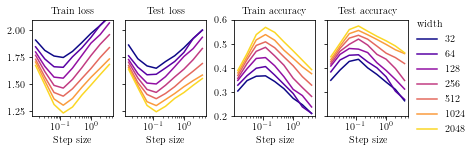

In [16]:
width_list = [32, 64, 128, 256, 512, 1024, 2048]
lr_list = [0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0]
colors = [colormap(i) for i in np.linspace(0.0, 0.92, len(width_list))]

fig, axes = plt.subplots(1, 4, sharex=True, constrained_layout=True)
fig.set_figheight(2)

keys = ['train_loss', 'test_loss', 'train_acc', 'test_acc']
titles = ['Train loss', 'Test loss', 'Train accuracy', 'Test accuracy']

print_args = True

tag = "resmlp_width_sweep"

for key_idx, (key, title) in enumerate(zip(keys,titles)):
    for color, width in zip(colors, width_list):
        curve = []
        for lr in lr_list:
            args, results = get_logs(f"../logs/{tag}/{width}/{lr}")
            if print_args: print(args); print_args = False
            if 'train' in key:
                result = np.mean(results[key][-100:])
            else:
                result = results[key][-1]
            curve.append(result)
        axes[key_idx].plot(lr_list, curve, color=color, label=width)
        axes[key_idx].set_title(title)
        axes[key_idx].set_xlabel("Step size")
        if 'loss' in key: axes[key_idx].set_ylim(1.2,2.1)
        if 'acc' in key: axes[key_idx].set_ylim(0.2, 0.6)

axes[1].set_yticklabels([])
axes[3].set_yticklabels([])

plt.legend(title="width", bbox_to_anchor=(1.0, 1.1))._legend_box.align = "left"

plt.xscale('log')
fig.savefig(f"{tag}.pdf")
plt.show()

{'cpu': False, 'log_dir': 'logs/resmlp_depth_sweep/2/0.015625', 'log_interval': 100, 'seed': 0, 'batch_size': 128, 'train_steps': 10000, 'test_steps': 100, 'dataset': 'cifar10', 'arch': 'resmlp', 'depth': 2, 'blockdepth': 2, 'width': 128, 'optim': 'mgd', 'loss': 'xent', 'lr': 0.015625, 'beta': 0.9, 'wd': 0.01}


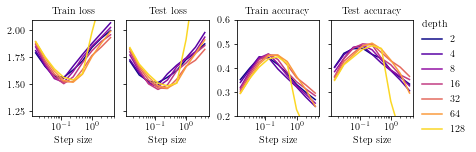

In [13]:
depth_list = [2, 4, 8, 16, 32, 64, 128]
lr_list = [0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0]
colors = [colormap(i) for i in np.linspace(0.0, 0.92, len(depth_list))]

fig, axes = plt.subplots(1, 4, sharex=True, constrained_layout=True)
fig.set_figheight(2)

keys = ['train_loss', 'test_loss', 'train_acc', 'test_acc']
titles = ['Train loss', 'Test loss', 'Train accuracy', 'Test accuracy']

print_args = True

tag = "resmlp_depth_sweep"

for key_idx, (key, title) in enumerate(zip(keys,titles)):
    for color, depth in zip(colors, depth_list):
        curve = []
        for lr in lr_list:
            args, results = get_logs(f"../logs/{tag}/{depth}/{lr}")
            if print_args: print(args); print_args = False
            if 'train' in key:
                result = np.mean(results[key][-100:])
            else:
                result = results[key][-1]
            curve.append(result)
        axes[key_idx].plot(lr_list, curve, color=color, label=depth)
        axes[key_idx].set_title(title)
        axes[key_idx].set_xlabel("Step size")
        if 'loss' in key: axes[key_idx].set_ylim(1.2,2.1)
        if 'acc' in key: axes[key_idx].set_ylim(0.2, 0.6)

axes[1].set_yticklabels([])
axes[3].set_yticklabels([])

plt.legend(title="depth", bbox_to_anchor=(1.0, 1.1))._legend_box.align = "left"

plt.xscale('log')
fig.savefig(f"{tag}.pdf")
plt.show()

cpu                  0                   
log_dir              logs/sweep-depth/2/0.015625
log_interval         100                 
seed                 0                   
batch_size           128                 
train_steps          10000               
test_steps           100                 
dataset              cifar10             
arch                 resmlp              
depth                2                   
blockdepth           2                   
width                512                 
loss                 xent                
lr                   0.015625            
beta                 0.9                 
wd                   0.01                


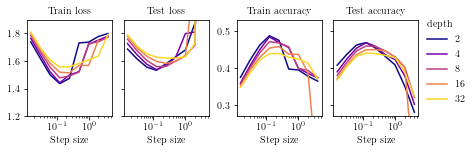

cpu                  0                   
log_dir              logs/sweep-depth-abs/2/0.015625
log_interval         100                 
seed                 0                   
batch_size           128                 
train_steps          10000               
test_steps           100                 
dataset              cifar10             
arch                 resmlp              
depth                2                   
blockdepth           2                   
width                512                 
loss                 xent                
lr                   0.015625            
beta                 0.9                 
wd                   0.01                


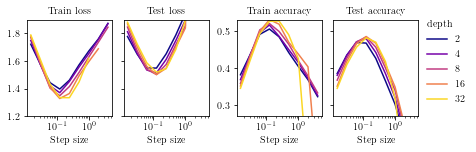

cpu                  0                   
log_dir              logs/sweep-depth-abs-middle/2/0.015625
log_interval         100                 
seed                 0                   
batch_size           128                 
train_steps          10000               
test_steps           100                 
dataset              cifar10             
arch                 resmlp              
depth                2                   
blockdepth           2                   
width                512                 
loss                 xent                
lr                   0.015625            
beta                 0.9                 
wd                   0.01                


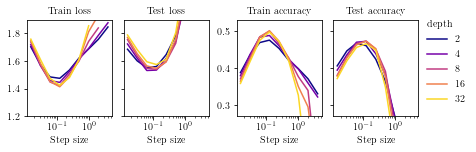

cpu                  0                   
log_dir              logs/sweep-depth-abs-ms-middle/2/0.015625
log_interval         100                 
seed                 0                   
batch_size           128                 
train_steps          10000               
test_steps           100                 
dataset              cifar10             
arch                 resmlp              
depth                2                   
blockdepth           2                   
width                512                 
loss                 xent                
lr                   0.015625            
beta                 0.9                 
wd                   0.01                


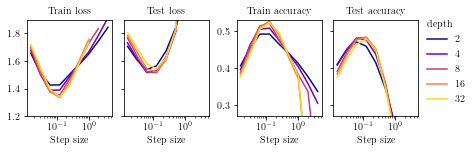

cpu                  0                   
log_dir              logs/sweep-depth-abs-ms-middle-no-wd/2/0.015625
log_interval         100                 
seed                 0                   
batch_size           128                 
train_steps          10000               
test_steps           100                 
dataset              cifar10             
arch                 resmlp              
depth                2                   
blockdepth           2                   
width                512                 
loss                 xent                
lr                   0.015625            
beta                 0.9                 
wd                   0.0                 


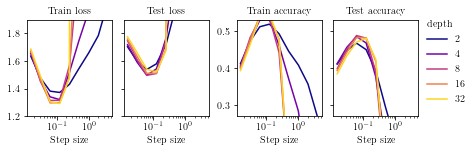

In [16]:
tag_list = ['sweep-depth', 'sweep-depth-abs', 'sweep-depth-abs-middle', 'sweep-depth-abs-ms-middle','sweep-depth-abs-ms-middle-no-wd']
# tag_list = ['sweep-depth-abs-ms-middle-no-wd']

# for offset in [-0.5, 0, 0.5]:
#     tag = 'sweep-depth-abs-ms-middle-no-wd'
for tag in tag_list:
    offset = 0.0

#     depth_list = [64, 128, 256]
#     depth_list = [2, 4, 8, 16, 32, 64, 128, 256]
    depth_list = [2, 4, 8, 16, 32]
    lr_list = [0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0]
    colors = [colormap(i) for i in np.linspace(0.0, 0.92, len(depth_list))]

    fig, axes = plt.subplots(1, 4, sharex=True, constrained_layout=True)
    fig.set_figheight(2)

    keys = ['train_loss', 'test_loss', 'train_acc', 'test_acc']
    titles = ['Train loss', 'Test loss', 'Train accuracy', 'Test accuracy']

    print_args = True

    for key_idx, (key, title) in enumerate(zip(keys,titles)):
        for color, depth in zip(colors, depth_list):
            curve = []
            for lr in lr_list:
                args, results = get_logs(f"../logs/{tag}/{depth}/{lr}")
                if print_args:
                    for arg in args: print("{: <20} {: <20}".format(arg, args[arg]))
                    print_args = False
                if True:#'train' in key and len(results[key]) == 9901:
                    result = np.mean(results[key][-100:])
                elif 'test' in key and len(results[key]) == 100:
                    result = np.mean(results[key][-100:])
                else:
                    result = float('nan')
                curve.append(result)
            scaled_lr_list = np.asarray(lr_list) * depth ** offset
            axes[key_idx].plot(scaled_lr_list, curve, color=color, label=depth)
            axes[key_idx].set_title(title)
            axes[key_idx].set_xlabel("Step size")
            if 'loss' in key: axes[key_idx].set_ylim(1.2,1.9)
            if 'acc' in key: axes[key_idx].set_ylim(0.27, 0.53)

    axes[1].set_yticklabels([])
    axes[3].set_yticklabels([])

    plt.legend(title="depth", bbox_to_anchor=(1.0, 1.1))._legend_box.align = "left"
    plt.xscale('log')
    fig.savefig(f"{tag}-offset{offset}.pdf")
    plt.show()